In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import time
import sys
sys.path.append('..')

1.12.0


In [2]:
from configs.rnn_biogas import hparams
hparams = hparams()
print(hparams)

[('batch_size', 800), ('datagen', 'biogas'), ('in_seq_len', 24), ('input_channels', 1), ('input_dim', 5), ('lambd', 1e-06), ('learning_rate', 0.01), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.99), ('neurons_unit', 32), ('norm_epsilon', 1e-12), ('num_layers', 1), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('test_split', 0.1), ('train_split', 0.8), ('val_split', 0.1)]


### Define Data Generator

In [3]:
from data_loader.biogas import *
get_fields = 'AT305'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields)

### Define Model

In [4]:
class RNN(tf.keras.Model):
    def __init__(self, output_dim, units, batch_size, dropout_rate=0.2):
        super(RNN, self).__init__()
        self.units = units
        self.output_dim = output_dim
        self.batch_sz = batch_size
        self.dropout_rate = dropout_rate
        self.training = True

        if tf.test.is_gpu_available():
            self.gru = tf.keras.layers.CuDNNGRU(self.units, return_sequences=True, return_state=True, name='gru')
        else:
            self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, 
                                           recurrent_activation='relu', name='gru')
        
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)

        self.fc_out = tf.keras.layers.Dense(self.output_dim, activation='relu', name='affine_out')

    def call(self, x, hidden):

        output, states = self.gru(x, initial_state=self.reset_states())

        x = self.fc_out(self.dropout(output, training=self.training))
        
        return x


### Train Model

Epoch 1 Loss 0.5741 Accuracy 0.5739
Time taken for 1 epoch 11.4622 sec

Epoch 2 Loss 0.0833 Accuracy 0.0831
Time taken for 1 epoch 0.3477 sec

Epoch 3 Loss 0.0527 Accuracy 0.0524
Time taken for 1 epoch 0.3461 sec

Epoch 4 Loss 0.0376 Accuracy 0.0374
Time taken for 1 epoch 0.3617 sec

Epoch 5 Loss 0.0299 Accuracy 0.0297
Time taken for 1 epoch 0.3612 sec

Epoch 6 Loss 0.0244 Accuracy 0.0241
Time taken for 1 epoch 0.3468 sec

Epoch 7 Loss 0.0227 Accuracy 0.0225
Time taken for 1 epoch 0.3511 sec

Epoch 8 Loss 0.0219 Accuracy 0.0217
Time taken for 1 epoch 0.3716 sec

Epoch 9 Loss 0.0212 Accuracy 0.0209
Time taken for 1 epoch 0.3580 sec

Epoch 10 Loss 0.0201 Accuracy 0.0199
Time taken for 1 epoch 0.3502 sec

Epoch 11 Loss 0.0194 Accuracy 0.0192
Time taken for 1 epoch 0.3588 sec

Epoch 12 Loss 0.0191 Accuracy 0.0189
Time taken for 1 epoch 0.3423 sec

Epoch 13 Loss 0.0188 Accuracy 0.0186
Time taken for 1 epoch 0.3528 sec

Epoch 14 Loss 0.0185 Accuracy 0.0183
Time taken for 1 epoch 0.3570 sec



Epoch 115 Loss 0.0042 Accuracy 0.0040
Time taken for 1 epoch 0.3469 sec

Epoch 116 Loss 0.0041 Accuracy 0.0040
Time taken for 1 epoch 0.3427 sec

Epoch 117 Loss 0.0041 Accuracy 0.0039
Time taken for 1 epoch 0.3480 sec

Epoch 118 Loss 0.0040 Accuracy 0.0039
Time taken for 1 epoch 0.3447 sec

Epoch 119 Loss 0.0040 Accuracy 0.0039
Time taken for 1 epoch 0.3431 sec

Epoch 120 Loss 0.0040 Accuracy 0.0038
Time taken for 1 epoch 0.3490 sec

Epoch 121 Loss 0.0039 Accuracy 0.0038
Time taken for 1 epoch 0.3430 sec

Epoch 122 Loss 0.0039 Accuracy 0.0037
Time taken for 1 epoch 0.3550 sec

Epoch 123 Loss 0.0039 Accuracy 0.0037
Time taken for 1 epoch 0.3811 sec

Epoch 124 Loss 0.0038 Accuracy 0.0037
Time taken for 1 epoch 0.3470 sec

Epoch 125 Loss 0.0038 Accuracy 0.0037
Time taken for 1 epoch 0.3502 sec

Epoch 126 Loss 0.0037 Accuracy 0.0036
Time taken for 1 epoch 0.3588 sec

Epoch 127 Loss 0.0037 Accuracy 0.0036
Time taken for 1 epoch 0.3739 sec

Epoch 128 Loss 0.0037 Accuracy 0.0035
Time taken fo

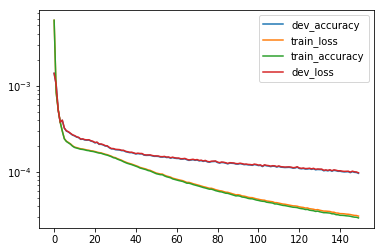

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (CuDNNGRU)               multiple                  3744      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
affine_out (Dense)           multiple                  33        
Total params: 3,777
Trainable params: 3,777
Non-trainable params: 0
_________________________________________________________________


In [5]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model = RNN(hparams.output_dim, hparams.neurons_unit, hparams.batch_size)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=150, verbose=True, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 100, accuracy * 100, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.yscale('log')
plt.show()

trainer.save_model(model, optimizer, dataset_val, hparams, 'rnn_affine_' + get_fields.replace(' ', '_'), stats=stats)
model.summary()

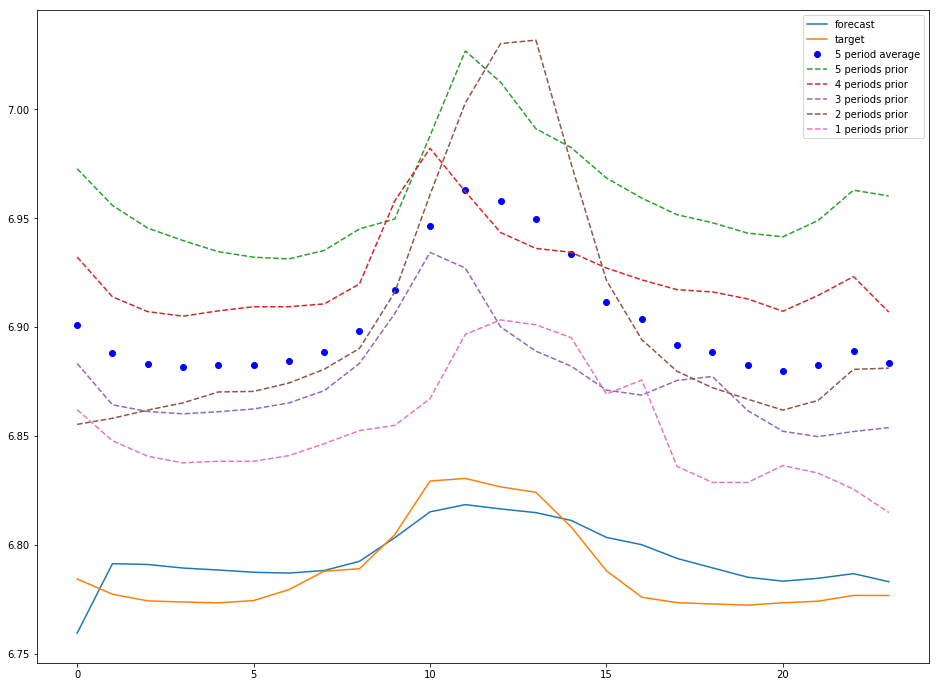

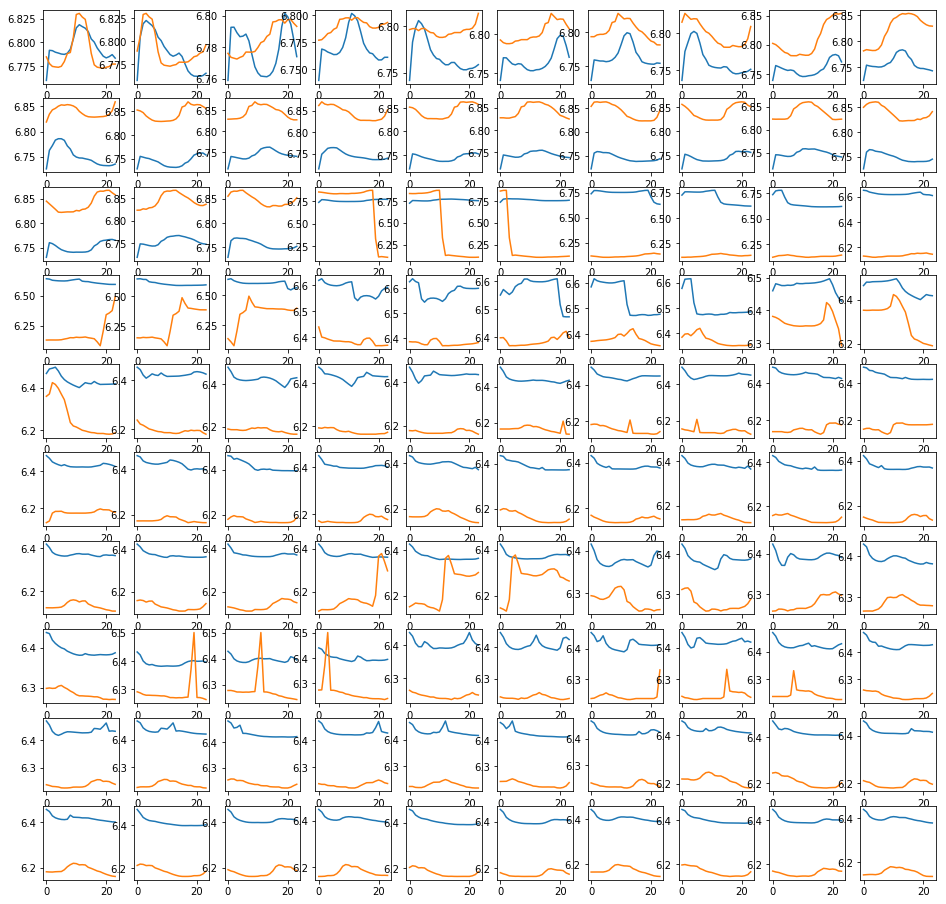

In [6]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = 0

# Create forecast and rescale data
inp, target, mask, x_max = next(iter(dataset))
hidden = model.reset_states()
model.training = False
forecast = model(inp, hidden)
forecast *= tf.keras.backend.expand_dims(x_max)
target   *= tf.keras.backend.expand_dims(x_max)
inp = np.reshape(inp, [hparams.batch_size, hparams.in_seq_len, hparams.input_dim, hparams.input_channels])
inp *= np.reshape(x_max, [hparams.batch_size,1,1,-1])

# Plot target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:,0]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX,:,0]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX,:,0], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.show()

# Plot specimen predictions
plt.figure(figsize=(16,16))
for i in range(0,800,8):
    ax = plt.subplot(10,10,i/8+1)
    ax.plot(np.squeeze(forecast[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

### Test Hyperparameters

In [9]:
np.random.seed(231)
models = []

#for nodes in np.floor(2 ** np.arange(3,9)):
#for lr in np.random.uniform(-8, -1, 10):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model_ = RNN(hparams.output_dim, hparams.neurons_unit, hparams.batch_size)
    optimizer_ = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stats = trainer.train_model(model_, optimizer_, dataset, hparams, epochs = 20, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*100, accuracy * 100, run_time))
    
    models.append(model_)

Learning Rate -4.0000 Loss 0.1557 Accuracy 0.1555 Time 6.9
Learning Rate -3.5000 Loss 0.1037 Accuracy 0.1035 Time 6.8
Learning Rate -3.0000 Loss 0.0471 Accuracy 0.0469 Time 7.0
Learning Rate -2.5000 Loss 0.0233 Accuracy 0.0231 Time 6.8
Learning Rate -2.0000 Loss 0.0176 Accuracy 0.0174 Time 6.9
Learning Rate -1.5000 Loss 0.0133 Accuracy 0.0127 Time 6.8
Learning Rate -1.0000 Loss 2.7415 Accuracy 2.7345 Time 6.9
Learning Rate -0.5000 Loss 2.7774 Accuracy 2.7344 Time 6.7


## Test Model Accuracy

In [7]:
model_accuracy = []

Train Results
Total RSE Accuracy: 0.1955
Total MSE Accuracy: 0.0172


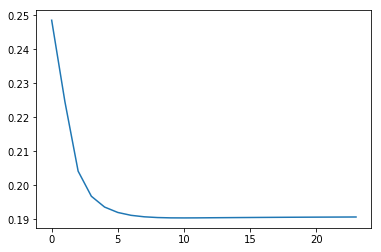

Test Results
Total RSE Accuracy: 0.1306
Total MSE Accuracy: 0.0115


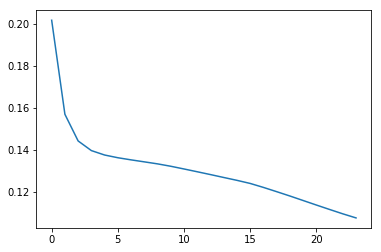

In [18]:
for name, dataset_eval in([['Train', dataset], ['Test', dataset_test]]):
    print(name + ' Results')
    total_accuracy = []
    x_variance = x_var(hparams, mode=get_fields)

    for i, (inp, target, mask, x_max) in enumerate(dataset_eval):
        forecast = model(inp, mask)

        accuracy = tf.squeeze(forecast - target) * x_max
        accuracy = accuracy ** 2 / x_variance
        accuracy = np.mean(accuracy, axis=0)

        total_accuracy.append(accuracy)

    model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))

    print('Total RSE Accuracy: %.4f' % np.mean(total_accuracy))
    print('Total MSE Accuracy: %.4f' % (np.mean(total_accuracy) * x_variance))
    plt.plot(np.mean(total_accuracy, axis=0))
    plt.show()